In [1]:
from sklearn.cluster import KMeans

In [ ]:
def k_means(X, n_clusters, init='k-means++', precompute_distances='auto',
            n_init=10, max_iter=300, verbose=False,
            tol=1e-4, random_state=None, copy_x=True, n_jobs=1,
            algorithm="auto", return_n_iter=False):
    X = as_float_array(X, copy=copy_x)
    tol = _tolerance(X, tol)

    if precompute_distances == 'auto':
        n_samples = X.shape[0]
        precompute_distances = (n_clusters * n_samples) < 12e6
    elif isinstance(precompute_distances, bool):
        pass
    else:
        raise ValueError("precompute_distances should be 'auto' or True/False"
                         ", but a value of %r was passed" %
                         precompute_distances)

    # Validate init array
    if hasattr(init, '__array__'):
        init = check_array(init, dtype=X.dtype.type, copy=True)
        _validate_center_shape(X, n_clusters, init)

        if n_init != 1:
            warnings.warn(
                'Explicit initial center position passed: '
                'performing only one init in k-means instead of n_init=%d'
                % n_init, RuntimeWarning, stacklevel=2)
            n_init = 1

    # subtract of mean of x for more accurate distance computations
    if not sp.issparse(X):
        X_mean = X.mean(axis=0)
        # The copy was already done above
        X -= X_mean

        if hasattr(init, '__array__'):
            init -= X_mean

    # precompute squared norms of data points
    x_squared_norms = row_norms(X, squared=True)

    best_labels, best_inertia, best_centers = None, None, None
    if n_clusters == 1:
        algorithm = "full"
    if algorithm == "auto":
        algorithm = "full" if sp.issparse(X) else 'elkan'
    if algorithm == "full":
        kmeans_single = _kmeans_single_lloyd
    elif algorithm == "elkan":
        kmeans_single = _kmeans_single_elkan
    else:
        raise ValueError("Algorithm must be 'auto', 'full' or 'elkan', got"
                         " %s" % str(algorithm))
    if n_jobs == 1:
        # For a single thread, less memory is needed if we just store one set
        # of the best results (as opposed to one set per run per thread).
        for it in range(n_init):
            # run a k-means once
            labels, inertia, centers, n_iter_ = kmeans_single(
                X, n_clusters, max_iter=max_iter, init=init, verbose=verbose,
                precompute_distances=precompute_distances, tol=tol,
                x_squared_norms=x_squared_norms, random_state=random_state)
            # determine if these results are the best so far
            if best_inertia is None or inertia < best_inertia:
                best_labels = labels.copy()
                best_centers = centers.copy()
                best_inertia = inertia
                best_n_iter = n_iter_
    else:
        # parallelisation of k-means runs
        seeds = random_state.randint(np.iinfo(np.int32).max, size=n_init)
        results = Parallel(n_jobs=n_jobs, verbose=0)(
            delayed(kmeans_single)(X, n_clusters, max_iter=max_iter, init=init,
                                   verbose=verbose, tol=tol,
                                   precompute_distances=precompute_distances,
                                   x_squared_norms=x_squared_norms,
                                   # Change seed to ensure variety
                                   random_state=seed)
            for seed in seeds)
        # Get results with the lowest inertia
        labels, inertia, centers, n_iters = zip(*results)
        best = np.argmin(inertia)
        best_labels = labels[best]
        best_inertia = inertia[best]
        best_centers = centers[best]
        best_n_iter = n_iters[best]

    if not sp.issparse(X):
        if not copy_x:
            X += X_mean
        best_centers += X_mean

    if return_n_iter:
        return best_centers, best_labels, best_inertia, best_n_iter
    else:
        return best_centers, best_labels, best_inertia

In [ ]:
def _kmeans_single_elkan(X, n_clusters, max_iter=300, init='k-means++',
                         verbose=False, x_squared_norms=None,
                         random_state=None, tol=1e-4,
                         precompute_distances=True):
    X = check_array(X, order="C")
    random_state = check_random_state(random_state)
    if x_squared_norms is None: x_squared_norms = row_norms(X, squared=True)
    centers = _init_centroids(X, n_clusters, init, random_state=random_state,
                              x_squared_norms=x_squared_norms)
    centers = np.ascontiguousarray(centers)
    if verbose:
        print('Initialization complete')
    centers, labels, n_iter = k_means_elkan(X, n_clusters, centers, tol=tol,
                                            max_iter=max_iter, verbose=verbose)
    inertia = np.sum((X - centers[labels]) ** 2, dtype=np.float64)
    return labels, inertia, centers, n_iter

In [107]:
wnh = np.array(widths_and_hightes)

In [112]:
from sklearn.metrics import pairwise_distances_argmin

def argmax_pairwise_iou(X, Y):
    max_val = 0
    argmaxes = []
    for x in X:
        for y in Y:
            val = iou(x, y)
            if val > max_val:
                max_val = val
                argmax = y
        argmaxes.append(argmax)
    return np.stack(argmaxes)

def find_clusters(X, n_clusters, rseed=2):
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    
    while True:
        labels = argmax_pairwise_iou(X, centers)
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)])
        print(1)
        if np.all(centers == new_centers):
            break
        centers = new_centers
    return centers, labels

centers, labels = find_clusters(wnh, 4)


1


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice.
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


IndexError: invalid index to scalar variable.

In [84]:
import random
import numpy as np
from scipy.spatial.distance import cdist
from scipy.sparse import issparse
import itertools

def _IoU_metric(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    # compute the area of intersection rectangle
    interArea = (xB - xA + 1) * (yB - yA + 1)
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # return the intersection over union value
    return -max(0,iou)

def IoU_metric(boxesA, boxesB):
    result = np.zeros((len(boxesA),len(boxesB)))
    for i in range(len(boxesA)):
        for j in range(len(boxesB)):
            result[i][j] = _IoU_metric(boxesA[i],boxesB[j])
    return result
    #return np.array([_IoU_metric(BoxA, BoxB) for BoxA, BoxB in zip(boxesA, boxesB)])
    
#...............................................................................
def kmeans( X, centres, delta=.001, maxiter=10, metric="euclidean", p=2, verbose=1 ):
    """ centres, Xtocentre, distances = kmeans( X, initial centres ... )
    in:
        X N x dim  may be sparse
        centres k x dim: initial centres, e.g. random.sample( X, k )
        delta: relative error, iterate until the average distance to centres
            is within delta of the previous average distance
        maxiter
        metric: any of the 20-odd in scipy.spatial.distance
            "chebyshev" = max, "cityblock" = L1, "minkowski" with p=
            or a function( Xvec, centrevec ), e.g. Lqmetric below
        p: for minkowski metric -- local mod cdist for 0 < p < 1 too
        verbose: 0 silent, 2 prints running distances
    out:
        centres, k x dim
        Xtocentre: each X -> its nearest centre, ints N -> k
        distances, N
    see also: kmeanssample below, class Kmeans below.
    """
    if not issparse(X):
        X = np.asanyarray(X)  # ?
    centres = centres.todense() if issparse(centres) \
        else centres.copy()
    N, dim = X.shape
    k, cdim = centres.shape
    if dim != cdim:
        raise ValueError( "kmeans: X %s and centres %s must have the same number of columns" % (X.shape, centres.shape ))
    
         
    allx = np.arange(N)
    prevdist = 0
    for jiter in range( 1, maxiter+1 ):
        D = cdist_sparse( X, centres, metric=metric, p=p )  # |X| x |centres|
        xtoc = D.argmin(axis=1)  # X -> nearest centre
        distances = D[allx,xtoc]
        avdist = distances.mean()  # median ?
        
             
        if (1 - delta) * prevdist <= avdist <= prevdist \
        or jiter == maxiter:
            break
        prevdist = avdist
        for jc in range(k):  # (1 pass in C)
            c = np.where( xtoc == jc )[0]
            if len(c) > 0:
                centres[jc] = X[c].mean( axis=0 )
                
        r50 = np.zeros(k)
        r90 = np.zeros(k)
        for j in range(k):
            dist = distances[ xtoc == j ]
            if len(dist) > 0:
                r50[j], r90[j] = np.percentile( dist, (50, 90) )
         
         
            # scale L1 / dim, L2 / sqrt(dim) ?
    return centres, xtoc, distances

#...............................................................................
def kmeanssample( X, k, nsample=0, **kwargs ):
    """ 2-pass kmeans, fast for large N:
        1) kmeans a random sample of nsample ~ sqrt(N) from X
        2) full kmeans, starting from those centres
    """
        # merge w kmeans ? mttiw
        # v large N: sample N^1/2, N^1/2 of that
        # seed like sklearn ?
    N, dim = X.shape
    if nsample == 0:
        nsample = max( 2*np.sqrt(N), 10*k )
    Xsample = randomsample( X, int(nsample) )
    pass1centres = randomsample( X, int(k) )
    samplecentres = kmeans( Xsample, pass1centres, **kwargs )[0]
    return kmeans( X, samplecentres, **kwargs )

def cdist_sparse( X, Y, **kwargs ):
    """ -> |X| x |Y| cdist array, any cdist metric
        X or Y may be sparse -- best csr
    """
        # todense row at a time, v slow if both v sparse
    sxy = 2*issparse(X) + issparse(Y)
    if sxy == 0:
        d = cdist( X, Y, **kwargs ) if metric != 'IoU' else IoU_metric(X, Y)
        return d
    d = np.empty( (X.shape[0], Y.shape[0]), np.float64 )
    if sxy == 2:
        for j, x in enumerate(X):
            d[j] = cdist( x.todense(), Y, **kwargs ) [0] if metric != 'IoU' else  IoU_metric(np.array([x]), Y)
    elif sxy == 1:
        for k, y in enumerate(Y):
            d[:,k] = cdist( X, y.todense(), **kwargs ) [0] if metric != 'IoU' else  IoU_metric(X, np.array([y]))
    else:
        for j, x in enumerate(X):
            for k, y in enumerate(Y):
                d[j,k] = cdist( x.todense(), y.todense(), **kwargs )[0] if metric != 'IoU' else  IoU_metric(np.array([x]), np.array([y]))
    return d

def randomsample( X, n ):
    """ random.sample of the rows of X
        X may be sparse -- best csr
    """
    sampleix = random.sample( range( X.shape[0] ), int(n) )
    return X[sampleix]

def nearestcentres( X, centres, metric="euclidean", p=2 ):
    """ each X -> nearest centre, any metric
            euclidean2 (~ withinss) is more sensitive to outliers,
            cityblock (manhattan, L1) less sensitive
    """
    D = cdist( X, centres, metric=metric, p=p ) if metric != 'IoU' else  IoU_metric(X, centres) # |X| x |centres|
    return D.argmin(axis=1)

def Lqmetric( x, y=None, q=.5 ):
    # yes a metric, may increase weight of near matches; see ...
    return (np.abs(x - y) ** q) .mean() if y is not None \
        else (np.abs(x) ** q) .mean()

#...............................................................................
class Kmeans:
    """ km = Kmeans( X, k= or centres=, ... )
        in: either initial centres= for kmeans
            or k= [nsample=] for kmeanssample
        out: km.centres, km.Xtocentre, km.distances
        iterator:
            for jcentre, J in km:
                clustercentre = centres[jcentre]
                J indexes e.g. X[J], classes[J]
    """
    def __init__( self, X, k=0, centres=None, nsample=0, **kwargs ):
        self.X = X
        if centres is None:
            self.centres, self.Xtocentre, self.distances = kmeanssample(
                X, k=k, nsample=nsample, **kwargs )
        else:
            self.centres, self.Xtocentre, self.distances = kmeans(
                X, centres, **kwargs )

    def __iter__(self):
        for jc in range(len(self.centres)):
            yield jc, (self.Xtocentre == jc)

#...............................................................................


import random
import sys
from time import time


N = 10000
dim = 4
ncluster = 10
kmsample = 100  # 0: random centres, > 0: kmeanssample
kmdelta = .001
kmiter = 10
metric = "IoU"  # "chebyshev" = max, "cityblock" L1,  Lqmetric
seed = 1

#exec( "\n".join( sys.argv[1:] ))  # run this.py N= ...

np.set_printoptions( 1, threshold=200, edgeitems=5, suppress=True )
np.random.seed(seed)
random.seed(seed)

 
X = np.random.exponential( size=(N,dim) )
    # cf scikits-learn datasets/
t0 = time()
if kmsample > 0:
    centres, xtoc, dist = kmeanssample( X, ncluster, nsample=kmsample,
        delta=kmdelta, maxiter=kmiter, metric=metric, verbose=2 )
else:
    randomcentres = randomsample( X, ncluster )
    centres, xtoc, dist = kmeans( X, randomcentres,
        delta=kmdelta, maxiter=kmiter, metric=metric, verbose=2 )

In [85]:
centres

array([[0.7, 1. , 1.3, 2.4],
       [1.3, 2.1, 0.6, 0.5],
       [0.7, 0.5, 1.3, 0.8],
       [0.7, 0.7, 0.5, 0.8],
       [1.4, 1.1, 0.7, 0.9],
       [2.3, 0.9, 0.5, 1. ],
       [1.1, 1.8, 0.8, 0.6],
       [1.3, 1.4, 1. , 0.6],
       [1.4, 1.5, 0.6, 0.7],
       [1.1, 1.5, 0.8, 0.7]])

In [36]:
from scipy.spatial.distance import cdist
import numpy as np
# cdist( X, centres, metric=metric, p=p ) if metric != 'IoU' else  IoU_metric(X, centres)
# dist1 = np.array([[1,2,3,4],[3,4,5,6],[4,5,6,7]])
# dist2 = np.array([[2,2,3,4],[4,4,5,6],[5,5,6,7],[0,0,1,1]])
dist1 = np.array([[1,2,3,4],[3,4,5,6],[4,5,6,7]])
dist2 = np.array([[2,2,3,4],[4,4,5,6],[5,5,6,7],[0,0,1,1]])
cdist(dist1, dist2), IoU_metric(dist1, dist2)

ValueError: XA must be a 2-dimensional array.

In [88]:
import pickle
with open('bblist', 'rb') as f:
    list_of_boxes = pickle.load(f)
list_of_boxes = list(map(lambda x: x['boundingBox'], list_of_boxes))

In [89]:
widths_and_hightes = list(map(lambda x: (x['Width'], x['Height']), list_of_boxes))

In [118]:
wnh = list(filter(lambda x: x[0]!=0 and x[1]!=0, widths_and_hightes))

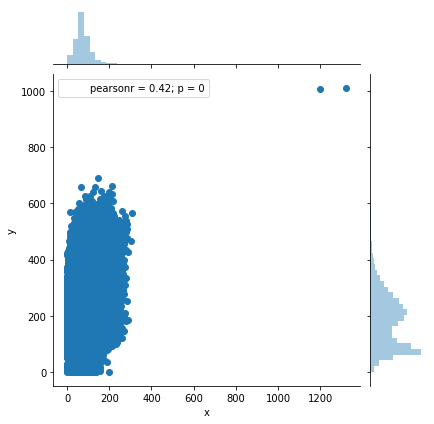

In [120]:
import pandas as pd
import seaborn as sns
df = pd.DataFrame(wnh, columns=["x", "y"])

sns.jointplot(df.x, df.y, )

In [121]:
from sklearn.cluster import KMeans

In [133]:
km = KMeans(5)

In [136]:
km = km.fit((df.x*df.y).values.reshape(-1,1))

In [137]:
km.cluster_centers_.reshape(-1)

array([13518.8, 39695.1,  4827.3, 24178.1, 67409.7])

In [65]:
def IoU_metric(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    # compute the area of intersection rectangle
    interArea = (xB - xA + 1) * (yB - yA + 1)
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # return the intersection over union value
    return iou

print(bb_intersection_over_union([1,1,3,3],[1,1,4,4]),9/16)
print(bb_intersection_over_union([1,1,2,2],[2,2,3,3]),1/7)



0.5625 0.5625
0.14285714285714285 0.14285714285714285


In [76]:
IoU_metric([0,0,10,50],[0,0,20,10])

0.18032786885245902

In [75]:
def iou(hw1, hw2):
    intersection = min(hw1[0],hw2[0])*min(hw1[1],hw2[1])
    union = np.prod(hw1)+np.prod(hw2) - intersection
    return intersection/union